# SASRec

### Self-Attentive Sequential Recommendation Using Transformer \[1\]

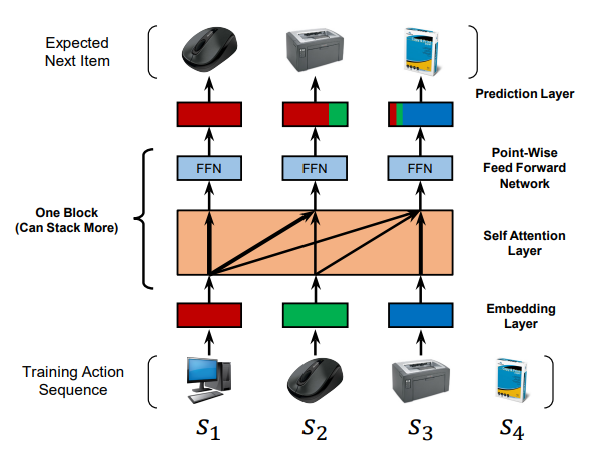

This is a class of sequential recommendation that uses Transformer \[2\] for encoding the users preference represented in terms of a sequence of items purchased/viewed before. Instead of using CNN (Caser \[3\]) or RNN (GRU4Rec \[4\], SLI-Rec \[5\] etc.) the approach relies on Transformer based encoder that generates a new representation of the item sequence. This notebook provides an example of necessary steps to train and test a SASRec model. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import logging
import papermill as pm
import scrapbook as sb
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd 

from collections import defaultdict
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED
from recommenders.models.deeprec.deeprec_utils import (
    prepare_hparams
)
from recommenders.datasets.amazon_reviews import download_and_extract, data_preprocessing
from recommenders.datasets.amazon_reviews import _reviews_preprocessing
from recommenders.datasets.download_utils import maybe_download
from recommenders.datasets.split_utils import min_rating_filter_pandas

# Transformer Based Models
from recommenders.models.sasrec.model import SASREC
from recommenders.models.sasrec.ssept import SSEPT

# Sampler for sequential prediction
from recommenders.models.sasrec.sampler import WarpSampler
from recommenders.models.sasrec.util import SASRecDataSet

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

/anaconda/envs/reco_gpu/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem
2022-01-21 09:50:22.978674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/:/opt/gurobi902/linux64/lib:/opt/gurobi902/linux64/lib
2022-01-21 09:50:22.978714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


System version: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Tensorflow version: 2.7.0


### Input Parameters

In [3]:
num_epochs = 5
batch_size = 128
RANDOM_SEED = 100  # Set None for non-deterministic result

# data_dir = "/recsys_data/RecSys/SASRec-tf2/data/"
data_dir = os.path.join("..", "..", "tests", "resources", "deeprec", "sasrec")

# Amazon Electronics Data (already converted into integer user-ids and item-ids)
dataset = "reviews_Electronics_5"

lr = 0.001             # learning rate
maxlen = 50            # maximum sequence length for each user
num_blocks = 2         # number of transformer blocks
hidden_units = 100     # number of units in the attention calculation
num_heads = 1          # number of attention heads
dropout_rate = 0.1     # dropout rate
l2_emb = 0.0           # L2 regularization coefficient
num_neg_test = 100     # number of negative examples per positive example

In [13]:
model_name = 'sasrec'  # 'sasrec' or 'ssept'
reviews_name = dataset + '.json'
outfile = dataset + '.txt'

reviews_file = os.path.join(data_dir, reviews_name)
if not os.path.exists(reviews_file):
    download_and_extract(reviews_name, reviews_file)
    reviews_output = _reviews_preprocessing(reviews_file)
else:
    reviews_output = os.path.join(data_dir, dataset+".json_output")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484k/484k [02:08<00:00, 3.77kKB/s]


In [17]:
def filter_K_core(data, min_rating=1, num_iter=5, col_user="userID", col_item="itemID"):
    """Filter rating dataframe for minimum number of users and items recursively
    """
    num_users, num_items = len(data[col_user].unique()), len(data[col_item].unique())
    print(f"Original: {num_users} users and {num_items} items")

    df = data.copy()
    for _ in range(num_iter):
        df = min_rating_filter_pandas(df, min_rating=min_rating, filter_by="item")
        df = min_rating_filter_pandas(df, min_rating=min_rating, filter_by="user")

    df = df.sort_values(by=[col_user])
    print(f"Final: {len(df[col_user].unique())} users and {len(df[col_item].unique())} items")

    return df

In [18]:
if not os.path.exists(os.path.join(data_dir, outfile)):
    df = pd.read_csv(reviews_output, sep="\t", names=["userID", "itemID", "time"])
    df = filter_K_core(df, min_rating=10, num_iter=1)
    
    user_set, item_set = set(df['userID'].unique()), set(df['itemID'].unique())
    user_map = dict()
    item_map = dict()
    for u, user in enumerate(user_set):
        user_map[user] = u+1
    for i, item in enumerate(item_set):
        item_map[item] = i+1
    
    df2 = df.copy()
    df2["userID"] = df2["userID"].apply(lambda x: user_map[x])
    df2["itemID"] = df2["itemID"].apply(lambda x: item_map[x])
    df2 = df2.sort_values(by=["userID", "time"])
    df2.drop(columns=["time"], inplace=True)
    df2.to_csv(os.path.join(data_dir, outfile), sep="\t", header=False, index=False)

Original: 192403 users and 63001 items
Final: 36262 users and 34988 items


SASRec requires sequence input and sequence target. Targets are for both positive and negative examples. Inputs to the model are 

* user's item history as input to the transformer
* user's item history shifted (by 1) as target to the transformer (positive examples)
* a sequence of items that are not equal to the positive examples (negative examples)

From each user's history three samples are created. If there are $N_u$ items for user-$u$ then $N_u-2$ items are used in training and the last two items are used for validation and testing, respectively. 

## Dataset Format 

- The input files should have the following format:
    - each row has user-id and item-id converted into integers (starting from 1)
    - the rows are sorted by user-id and time of interaction
    - for every user the last item is used for testing and the last but one is used for validation
    - for example, for user `30449` the sorted inputs are:
        - `30449 2771`
        - `30449 61842`
        - `30449 60293`
        - `30449 30047`
        - `30449 63296`
        - `30449 22042`
        - `30449 6717`
        - `30449 75780`
      
      then the train inputs are 
        - [`2771`, `61842`, `60293`, `30047`, `63296`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`] (target sequence for positive examples)
        - [`1001`, `50490`, `33312`, `19294`, `45342`] (sample negative examples)

      and the validation inputs are 
        - [`2771`, `61842`, `60293`, `30047`, `63296`, `22042`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`, `6717`] (target sequence for positive examples)
        - [`4401`, `60351`, `22176`, `23456`, `45342`, '1193`] (sample negative examples)
        
      and the test inputs are 
        - [`2771`, `61842`, `60293`, `30047`, `63296`, `22042`, `6717`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`, `6717`, `75780`] (target sequence for positive examples)
        - [`4401`, `60351`, `22176`, `23456`, `45342`, '1193`, `54231`] (sample negative examples)
    

In [19]:
inp_file = os.path.join(data_dir, dataset + ".txt")
print(inp_file)

# initiate a dataset class 
data = SASRecDataSet(filename=inp_file, col_sep="\t")

# create train, validation and test splits
data.split()

# some statistics
num_steps = int(len(data.user_train) / batch_size)
cc = 0.0
for u in data.user_train:
    cc += len(data.user_train[u])
print('%g Users and %g items' % (data.usernum, data.itemnum))
print('average sequence length: %.2f' % (cc / len(data.user_train)))

../../tests/resources/deeprec/sasrec/reviews_Electronics_5.txt
36262 Users and 34988 items
average sequence length: 15.01


### Model Creation

Model parameters are 
    - number of items
    - maximum sequence length of the user interaction history
    - number of Transformer blocks
    - embedding dimension for item embedding
    - dimension of the attention
    - number of attention heads
    - dropout rate
    - dimension of the convolution layers, list
    - L_2-regularization coefficient

In [20]:
if model_name == 'sasrec':
    model = SASREC(item_num=data.itemnum,
                   seq_max_len=maxlen,
                   num_blocks=num_blocks,
                   embedding_dim=hidden_units,
                   attention_dim=hidden_units,
                   attention_num_heads=num_heads,
                   dropout_rate=dropout_rate,
                   conv_dims = [100, 100],
                   l2_reg=l2_emb,
                   num_neg_test=num_neg_test
    )
elif model_name == "ssept":
    model = SSEPT(item_num=data.itemnum,
                  user_num=data.usernum,
                  seq_max_len=maxlen,
                  num_blocks=num_blocks,
                  # embedding_dim=hidden_units,  # optional
                  user_embedding_dim=hidden_units,
                  item_embedding_dim=hidden_units,
                  attention_dim=hidden_units,
                  attention_num_heads=num_heads,
                  dropout_rate=dropout_rate,
                  conv_dims = [200, 200],
                  l2_reg=l2_emb,
                  num_neg_test=num_neg_test
    )
else:
    print(f"Model-{model_name} not found")

### Sampler

    - the sampler creates negative samples from the training data for each batch
    - this is done by looking at the original user interaction history and creating items that are not present at all
    - the sampler generates a sequence of negative items of the same length as the original history

In [21]:
sampler = WarpSampler(data.user_train, data.usernum, data.itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=3)

### Model Training

    - the loss function is defined over all the negative and positive logits
    - a mask has to be applied to indicate the non-zero items present in the output
    - we also add the regularization loss here
    
    - having a train-step signature function can speed up the training process

In [22]:
with Timer() as train_time:
    t_test = model.train(data, sampler, num_epochs=10, batch_size=batch_size, lr=lr, val_epoch=6)

print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))

Evaluating...



epoch: 6, time: 157.43903495697305, valid (NDCG@10: 0.36348764732540256, HR@10: 0.5691)
epoch: 6, time: 157.43903495697305,  test (NDCG@10: 0.34526314769453337, HR@10: 0.5481)



epoch: 10, test (NDCG@10: 0.35404973832851994, HR@10: 0.5599)
Time cost for training is 19.45 mins


In [23]:
res_syn = {"ndcg@10": t_test[0], "Hit@10": t_test[1]}
print(res_syn)

{'ndcg@10': 0.35404973832851994, 'Hit@10': 0.5599}


In [12]:
# Record results with papermill for tests - ignore this cell
# sb.glue("res_syn", res_syn)

sb.glue("ndcg@10", t_test[0])
sb.glue("Hit@10", t_test[1])

## Reference
\[1\] Wang-Cheng Kang, Julian McAuley: Self-Attentive Sequential Recommendation, arXiv preprint arXiv:1808.09781 (2018) <br>

\[2\] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information Processing Systems. 5998–6008 <br>

\[3\] Jiaxi Tang and Ke Wang. 2018. Personalized top-n sequential recommendation via convolutional sequence embedding. In Proceedings of the Eleventh ACM International Conference on Web Search and Data Mining. ACM, 565–573.

\[4\] Balázs Hidasi, Alexandros Karatzoglou, Linas Baltrunas, and Domonkos Tikk. 2015. Session-based recommendations with recurrent neural networks. arXiv preprint arXiv:1511.06939 (2015)

\[5\] Zeping Yu, Jianxun Lian, Ahmad Mahmoody, Gongshen Liu, Xing Xie. Adaptive User Modeling with Long and Short-Term Preferences for Personailzed Recommendation. In Proceedings of the 28th International Joint Conferences on Artificial Intelligence, IJCAI’19, Pages 4213-4219. AAAI Press, 2019.